### Imports

In [2]:
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from tensorflow.keras import Model
from tensorflow.keras.layers import (ConvLSTM2D, Dense, GlobalAveragePooling2D,
                                     Dropout, BatchNormalization)
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import numpy as np
import sys
import cv2
import tempfile
import os
import matplotlib.pyplot as plt
import argparse

In [3]:
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

### Modelo

In [4]:
CHECKPOINT_DIR = "/mnt/DGX0Raid/aherrerag/Crime_Detection/notebooks/checkpoints/i3d_convlstm_1/best_model"

In [8]:
# Mejores hiperparámetros ya definidos
best_hyperparameters = {
    'kernel_size': (3, 3),
    'filters': 128,
    'dropout': 0.3,
    'recurrent_dropout': 0.5,
    'dense_units': 128,
    'dense_dropout': 0.5
}

# --- LOAD MODEL
def load_model():
    def build_model():
        class Tuned_I3D_ConvLSTM(Model):
            def __init__(self, num_classes):
                super().__init__()
                self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint="Mixed_5c")

                # Usar los mejores hiperparámetros directamente
                kernel_size = best_hyperparameters['kernel_size']
                self.conv_lstm = ConvLSTM2D(
                    filters=best_hyperparameters['filters'],
                    kernel_size=kernel_size,
                    padding='same',
                    return_sequences=False,
                    dropout=best_hyperparameters['dropout'],
                    recurrent_dropout=best_hyperparameters['recurrent_dropout'],
                    activation='tanh'
                )

                self.batch_norm = BatchNormalization()
                self.dense = Dense(best_hyperparameters['dense_units'], activation='relu')
                self.dropout = Dropout(best_hyperparameters['dense_dropout'])
                self.fc = Dense(num_classes, activation='sigmoid')

            def call(self, inputs, training=False):
                features, _ = self.i3d(inputs)
                x = self.conv_lstm(features)
                x = self.batch_norm(x, training=training)
                x = GlobalAveragePooling2D()(x)
                x = self.dense(x)
                x = self.dropout(x, training=training)
                return self.fc(x)

        num_classes = 2
        model = Tuned_I3D_ConvLSTM(num_classes=num_classes)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
        return model
    
    model = build_model()

    # Cargar los pesos si es necesario
    model.load_weights(CHECKPOINT_DIR)

    return model

### Procesamiento

In [14]:
import cv2
import numpy as np
import os
from IPython.display import display, clear_output
from PIL import Image
import time

NUM_FRAMES = 30
FRAME_SIZE = (224, 224)

def preprocess_frame(frame, frame_size=FRAME_SIZE):
    frame = cv2.resize(frame, frame_size)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame / 255.0

def predict_crime(model, frames_window):
    input_tensor = np.expand_dims(np.array(frames_window, dtype=np.float32), axis=0)
    prediction = model.predict(input_tensor)[0]
    return prediction

def simulate_realtime_from_video_notebook(video_path, model):
    cap = cv2.VideoCapture(video_path)
    buffer = []
    frame_count = 0
    print(f"\nAnalizando {video_path}...\n")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        preprocessed = preprocess_frame(frame)
        buffer.append(preprocessed)

        # Redimensionar para mostrar (sin normalizar ni convertir)
        display_frame = cv2.resize(frame, (640, 480))
        display_frame = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)

        if len(buffer) == NUM_FRAMES:
            prediction = predict_crime(model, buffer)
            prob_crime = prediction[1] * 100

            # Añadir texto al frame
            cv2.putText(display_frame,
                        f"Prob. crimen: {prob_crime:.2f}%",
                        (10, 30),  # posición del texto
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,  # tamaño fuente
                        (255, 0, 0),  # color (BGR)
                        2,  # grosor
                        cv2.LINE_AA)

            buffer.pop(0)  # mantener tamaño ventana

        # Mostrar en notebook
        clear_output(wait=True)
        display(Image.fromarray(display_frame))
        time.sleep(0.03)  # simular tiempo real (30 fps)

        frame_count += 1

    cap.release()

### Demo

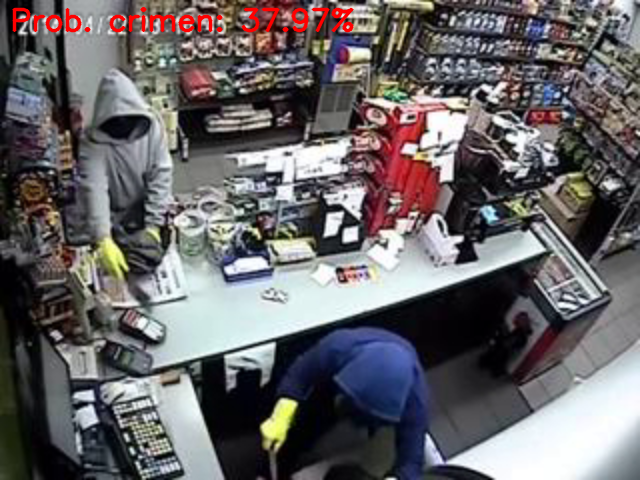

KeyboardInterrupt: 

In [15]:
print("Cargando modelo...")
model = load_model()

video_dir = "./videos"
video_files = [f for f in os.listdir(video_dir) if f.endswith((".mp4", ".avi"))]

if len(video_files) < 2:
    print("Se necesitan al menos dos videos en la carpeta /videos.")

for video_file in video_files[:2]:
    video_path = os.path.join(video_dir, video_file)
    simulate_realtime_from_video_notebook(video_path, model)